<a href="https://colab.research.google.com/github/JudzinasKrabas/Stock-prediction/blob/main/Stock_price_prediction_Apple_Inc_Using_LSTM_%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import yfinance as yf


In [88]:
config = {
    "yfinance": {
        "symbol": "Amzn",
        "period": "5y",  # '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
        "interval": "1d",  #'1d', '5d', '1wk', '1mo', '3mo'
    },
     "data": {
        "window_size": 20,
        "train_split_size": 0.8
    },

    "model": {
        "input_size": 1,
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },

    "plots": {
        "show_plots": True,
        "color_actual": "red",
        "xticks_interval": 10,
        "color_train": "#3D9970",
        "color_val": "#007ACC",
        "color_pred_train": "#3D9870",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",

    },
    "training": {
        "device": "cpu",
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 20,
    }
}

[*********************100%***********************]  1 of 1 completed


Number data points: 1259 from 2019-09-03 to 2024-09-03


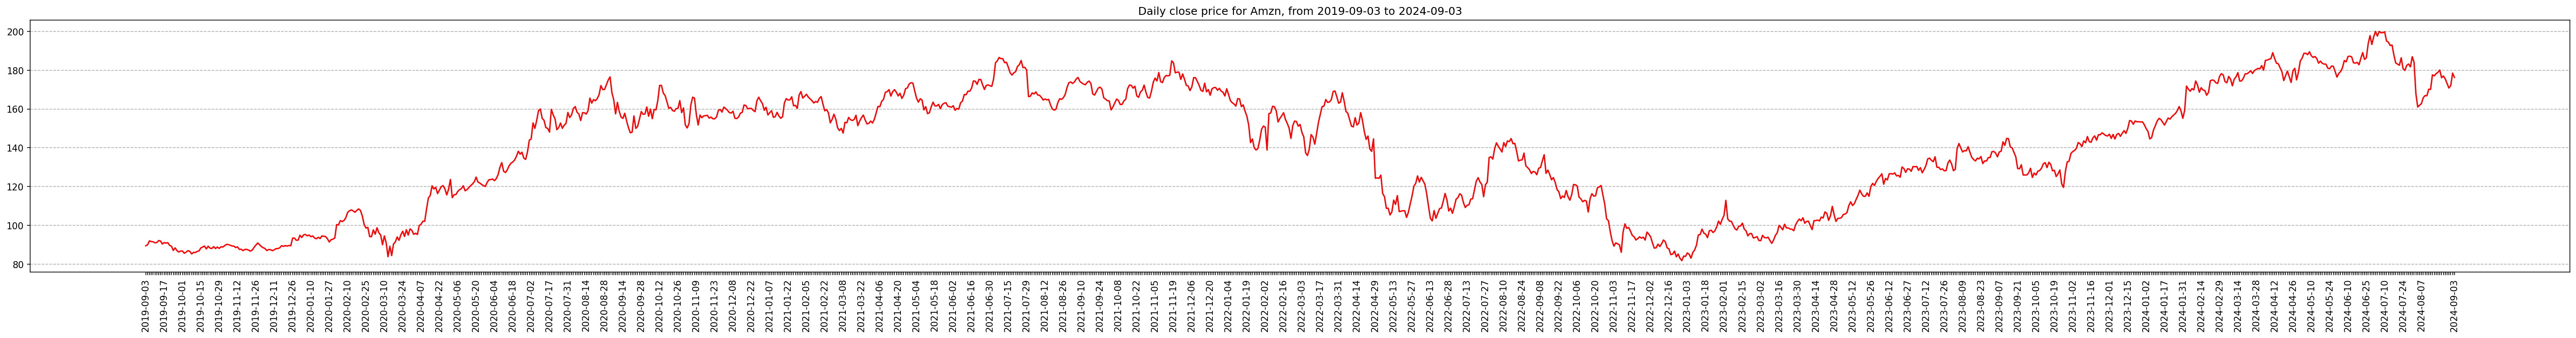

In [89]:

def download_data(config, plot=False):
    ticker = config["yfinance"]["symbol"]
    data = yf.download(ticker, period=config["yfinance"]["period"], interval=config["yfinance"]["interval"])


    data_date = data.index.strftime('%Y-%m-%d').tolist()
    data_close_price = data['Adj Close'].values
    normalized_data_close_price = (data_close_price - np.mean(data_close_price)) / np.std(data_close_price)
    scaler = StandardScaler()
    normalized_data_close_price = scaler.fit_transform(data_close_price.reshape(-1, 1)).flatten()
    num_data_points = len(data_date)
    display_date_range = f"from {data_date[0]} to {data_date[-1]}"
    print("Number data points:", num_data_points, display_date_range)

    if plot:

        fig = figure(figsize=(50, 5), dpi=150)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [
            data_date[i] if ((i % config["plots"]["xticks_interval"] == 0 and (num_data_points - i) > config["plots"]["xticks_interval"]) or i == num_data_points - 1)
            else None
            for i in range(num_data_points)
        ]  # make x ticks nice
        x = np.arange(0, len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title(f"Daily close price for {config['yfinance']['symbol']}, {display_date_range}")
        plt.grid( which='major', axis='y', linestyle='--')
        plt.show()

    return data, data_date, data_close_price, num_data_points, display_date_range



data, data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])


In [90]:
class Normalizer():
    def __init__(self):
        # Constructor initializes the mean (mu) and standard deviation (sd) attributes to None.
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        # Calculate the mean and standard deviation of the input data 'x' across the specified axis.
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        # Normalize the input data by subtracting the mean and dividing by the standard deviation.
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        # Reverts the normalization by applying the inverse transformation to the input data 'x'.
        return (x*self.sd) + self.mu


# Create an instance of the Normalizer class.
scaler = Normalizer()
# Normalize the 'data_close_price' using the fit_transform method and store the result.
normalized_data_close_price = scaler.fit_transform(data_close_price)

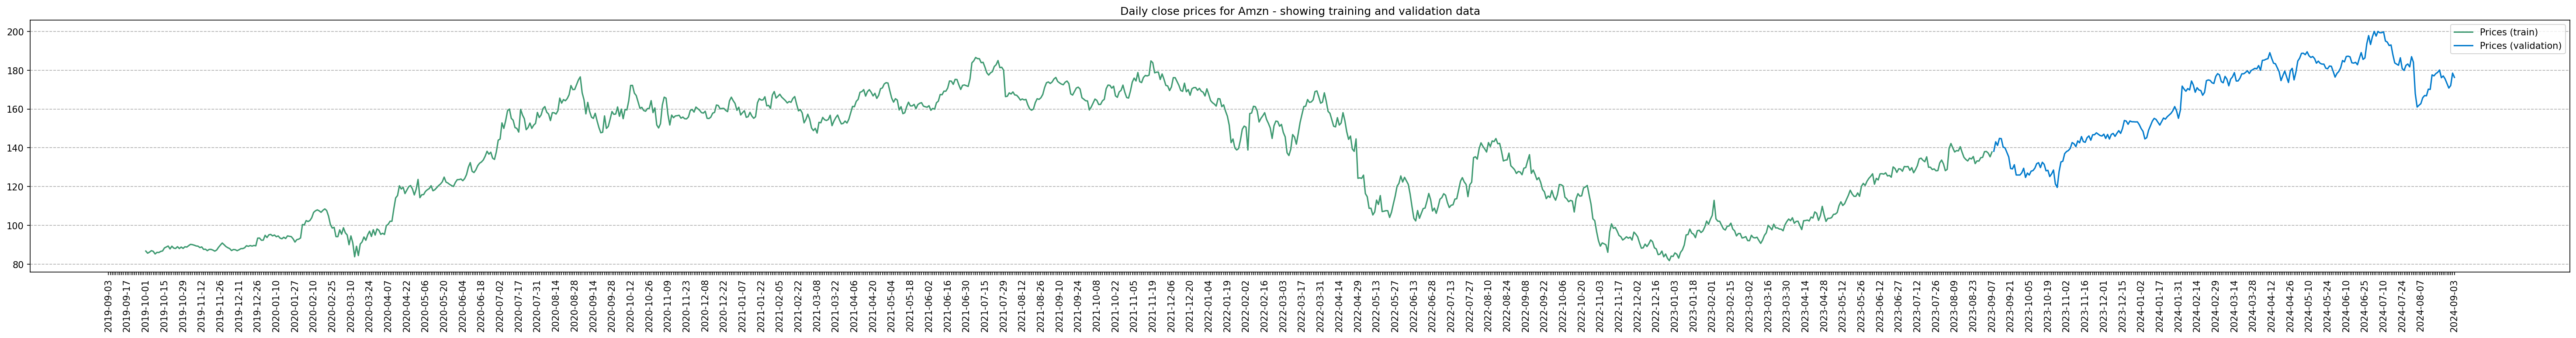

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def prepare_close_price_data(x, window_size):
    # Create sliding windows from the input data 'x' using the specified window size.
    n_row = x.shape[0] - window_size + 1
    # Utilize numpy's stride_tricks to create overlapping sub-arrays (windows) from the input data.
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]  # Return all windows except the last as data_x and the last as data_x_unseen.

def prepare_data_y(x, window_size):
    # Extract labels by shifting the data by the window size, effectively using the next day's value as the label.
    output = x[window_size:]
    return output  # Return the labels corresponding to the windows created in prepare_close_price_data.

def prepare_data(normalized_data_close_price, config, plot=False):
    # Prepare the input features and labels for model training and validation.
    data_x, data_x_unseen = prepare_close_price_data(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # Split the data into training and validation sets based on the specified split ratio.
    split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # If plotting is enabled, visualize the training and validation data.
        num_data_points = len(normalized_data_close_price)
        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        # Inverse transform the normalized data to plot it in its original scale.
        to_plot_data_y_train[config["data"]["window_size"]:split_index + config["data"]["window_size"]] = scaler.inverse_transform(data_y_train.reshape(-1, 1)).flatten()
        to_plot_data_y_val[split_index + config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val.reshape(-1, 1)).flatten()

        # Replace zeros with None to avoid plotting them.
        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        # Set up the figure for plotting.
        fig = figure(figsize=(50, 5), dpi=150)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        # Plot the training and validation data.
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])

        # Customize x-axis ticks based on the specified interval.
        xticks = [
            data_date[i] if ((i % config["plots"]["xticks_interval"] == 0 and (num_data_points - i) > config["plots"]["xticks_interval"]) or i == num_data_points - 1)
            else None
            for i in range(num_data_points)
        ]
        x = np.arange(0, len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title(f"Daily close prices for {config['yfinance']['symbol']} - showing training and validation data")
        plt.grid( which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    # Return the split index and the prepared datasets.
    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

# Call the prepare_data function with the normalized data and configuration to obtain training and validation sets.
split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])



In [92]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        # Initialize the dataset by expanding the dimensions of 'x' and converting both 'x' and 'y' to float32.
        x = np.expand_dims(x, 2)  # Add an additional dimension to 'x' (e.g., for use with convolutional layers).
        self.x = x.astype(np.float32)  # Convert input features to float32.
        self.y = y.astype(np.float32)  # Convert labels to float32.

    def __len__(self):
        # Return the number of samples in the dataset.
        return len(self.x)

    def __getitem__(self, idx):
        # Retrieve the input features and corresponding label for a given index 'idx'.
        return (self.x[idx], self.y[idx])

# Create instances of TimeSeriesDataset for training and validation data.
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

# Print the shapes of the training and validation datasets to verify their correctness.
print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (991, 20, 1) (991,)
Validation data shape (248, 20, 1) (248,)
Validation data shape (248, 20, 1) (248,)


In [93]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention_weights_layer = nn.Linear(hidden_size, hidden_size)
        self.context_vector = nn.Parameter(torch.randn(hidden_size))

    def forward(self, lstm_output):
        attention_weights = torch.tanh(self.attention_weights_layer(lstm_output))
        attention_weights = torch.matmul(attention_weights, self.context_vector)
        attention_weights = F.softmax(attention_weights, dim=1)
        attention_output = torch.sum(lstm_output * attention_weights.unsqueeze(-1), dim=1)
        return attention_output, attention_weights


In [94]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=1, output_size=1, dropout=0.2, bidirectional=False):
        # Initialize the LSTM model with specified parameters and layers.
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
            # Linear layer to transform the input features to the desired hidden layer size.
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()  # ReLU activation function for non-linearity.

        # Attention mechanism to capture long-term dependencies
        self.attention = Attention(hidden_layer_size)
        # LSTM layer(s) to capture temporal dependencies in the data.
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.memory_gate = nn.Sigmoid()  # Memory gate for the LSTM.
        # Dropout layer to prevent overfitting.
        self.dropout = nn.Dropout(dropout)

        # Linear layer to produce the final output, flattening the LSTM output if necessary.
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        # Initialize the weights of the LSTM layers.
        self.init_weights()

    def init_weights(self):
        # Custom weight initialization for the LSTM layers.
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)  # Initialize biases to zero.
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)  # Kaiming initialization for input weights.
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)  # Orthogonal initialization for hidden weights.

    def forward(self, x):
        # Forward pass through the network.
        batchsize = x.shape[0]
        x = self.linear_1(x)# Pass input through the first linear layer and apply ReLU activation.
        x = self.relu(x)
        lstm_out, (h_n, c_n) = self.lstm(x) # Pass the result through the LSTM layer(s).
        attn_output, attention_weights = self.attention(lstm_out) # Apply the attention mechanism.
        # Reshape the hidden state output for the final linear layer.
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)



        # Apply dropout for regularization.
        x = self.dropout(x)

        # Generate the final prediction using the second linear layer.
        predictions = self.linear_2(x)
        return predictions[:, -1]  # Return the last time step's prediction.

# Instantiate the LSTM model with configurations specified in the config dictionary.
model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])

# Move the model to the specified device (e.g., CPU or GPU).
model = model.to(config["training"]["device"])


In [95]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0  # Initialize the cumulative loss for the epoch.

    if is_training:
        model.train()  # Set the model to training mode (enables dropout and batchnorm layers).
    else:
        model.eval()  # Set the model to evaluation mode (disables dropout and batchnorm layers).

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()  # Clear the gradients of the optimizer.

        batchsize = x.shape[0]  # Get the batch size.

        # Move the input data and labels to the specified device (CPU or GPU).
        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)  # Forward pass through the model.
        loss = criterion(out.contiguous(), y.contiguous())  # Calculate the loss.

        if is_training:
            loss.backward()  # Backpropagate the loss.
            optimizer.step()  # Update the model parameters.

        # Accumulate the epoch loss, normalizing by batch size.
        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]  # Get the current learning rate.

    return epoch_loss, lr  # Return the loss for the epoch and the learning rate.

# Create DataLoaders for the training and validation datasets with specified batch sizes and shuffling.
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# Define the loss function (Mean Squared Error) and the optimizer (Adam).
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9, weight_decay=1e-5)

# Define a learning rate scheduler that reduces the learning rate by a factor of 0.1 every specified step size.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# Training loop to run for the specified number of epochs.
for epoch in range(config["training"]["num_epoch"]):
    # Run a training epoch and calculate training loss and learning rate.
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)

    # Run an evaluation epoch and calculate validation loss.
    loss_val, lr_val = run_epoch(val_dataloader)

    scheduler.step()  # Update the learning rate according to the scheduler.

    # Print out the results for each epoch.
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))



Epoch[1/100] | loss train:0.033506, test:0.002722 | lr:0.010000
Epoch[2/100] | loss train:0.007892, test:0.002969 | lr:0.010000
Epoch[3/100] | loss train:0.006303, test:0.001847 | lr:0.010000
Epoch[4/100] | loss train:0.006123, test:0.001869 | lr:0.010000
Epoch[5/100] | loss train:0.004932, test:0.001305 | lr:0.010000
Epoch[6/100] | loss train:0.004849, test:0.001304 | lr:0.010000
Epoch[7/100] | loss train:0.004452, test:0.001104 | lr:0.010000
Epoch[8/100] | loss train:0.004514, test:0.001071 | lr:0.010000
Epoch[9/100] | loss train:0.004880, test:0.000838 | lr:0.010000
Epoch[10/100] | loss train:0.004673, test:0.000918 | lr:0.010000
Epoch[11/100] | loss train:0.004653, test:0.000852 | lr:0.010000
Epoch[12/100] | loss train:0.005709, test:0.001805 | lr:0.010000
Epoch[13/100] | loss train:0.004983, test:0.001060 | lr:0.010000
Epoch[14/100] | loss train:0.004794, test:0.000728 | lr:0.010000
Epoch[15/100] | loss train:0.004291, test:0.000750 | lr:0.010000
Epoch[16/100] | loss train:0.00463

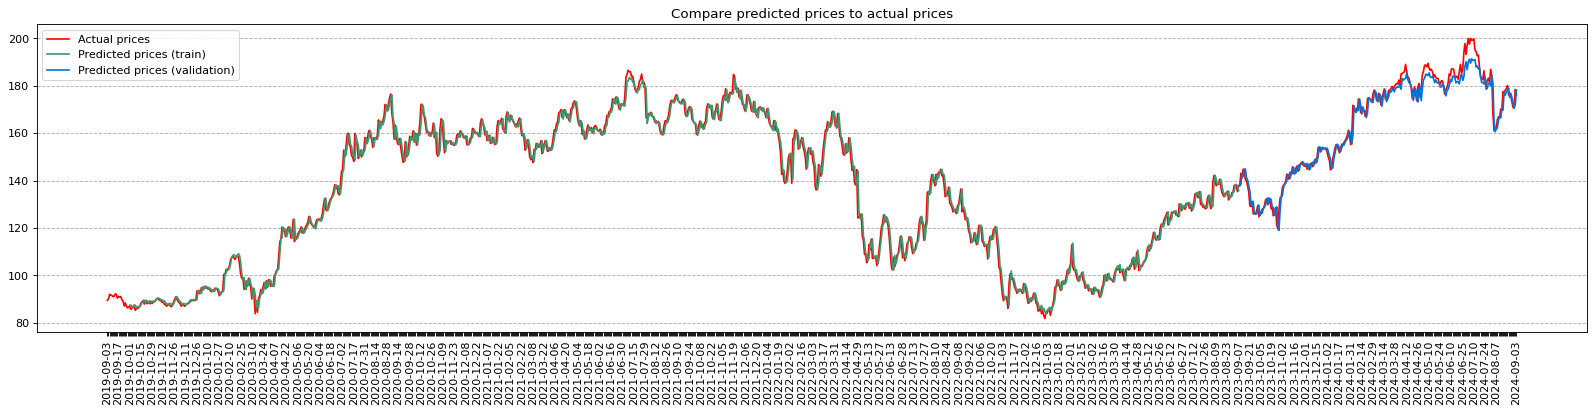

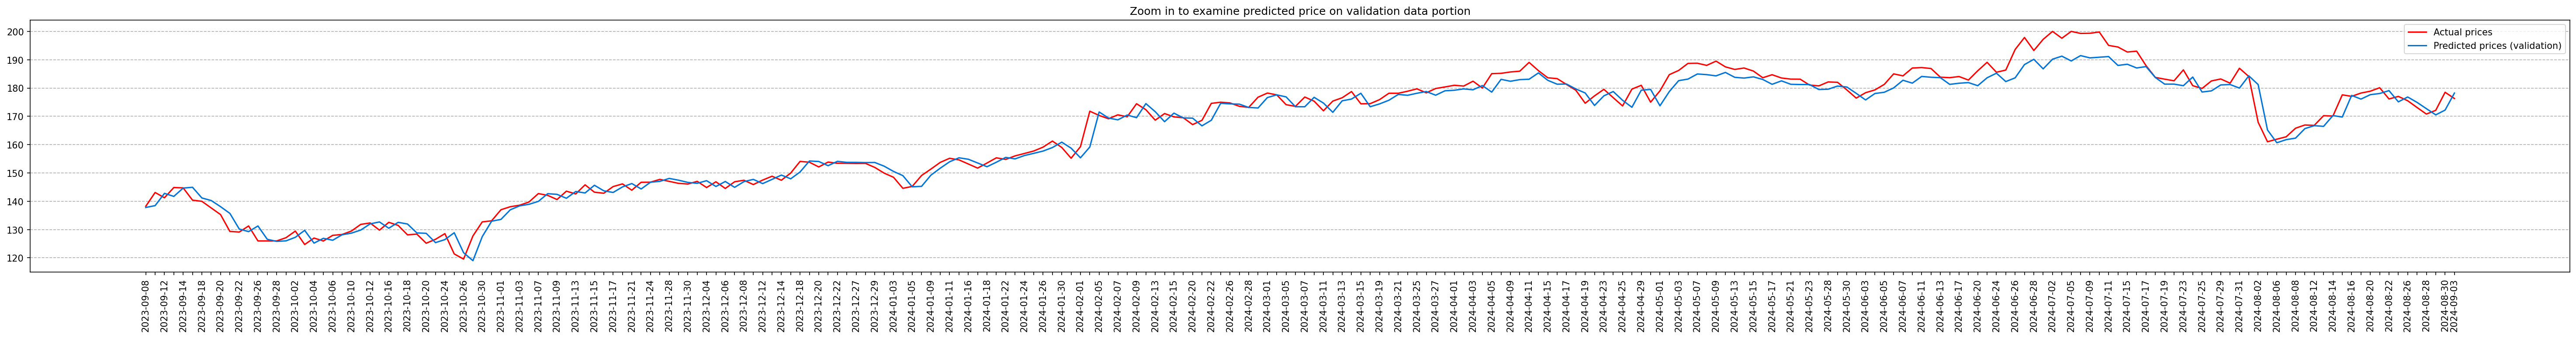

In [96]:
# Re-initialize DataLoaders without shuffling to maintain the chronological order of data for plotting.
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()  # Set the model to evaluation mode.

# Predict on the training data to evaluate how well the model learned and memorized the data.
predicted_train = np.array([])  # Initialize an empty array to store predictions on training data.

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])  # Move input data to the specified device (CPU or GPU).
    out = model(x)  # Generate predictions using the model.
    out = out.cpu().detach().numpy()  # Move predictions back to the CPU and convert to numpy array.
    predicted_train = np.concatenate((predicted_train, out))  # Append predictions to the array.

# Predict on the validation data to evaluate model performance on unseen data.
predicted_val = np.array([])  # Initialize an empty array to store predictions on validation data.

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])  # Move input data to the specified device.
    out = model(x)  # Generate predictions using the model.
    out = out.cpu().detach().numpy()  # Move predictions back to the CPU and convert to numpy array.
    predicted_val = np.concatenate((predicted_val, out))  # Append predictions to the array.

if config["plots"]["show_plots"]:
    # Prepare data for plotting predicted prices vs. actual prices.
    to_plot_data_y_train_pred = np.zeros(num_data_points)  # Initialize array for training predictions.
    to_plot_data_y_val_pred = np.zeros(num_data_points)  # Initialize array for validation predictions.

    # Inverse transform the normalized predictions to their original scale.
    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    # Replace zeros with None for better visualization.
    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # Plot actual prices vs. predicted prices for both training and validation data.
    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))  # Set background color to white.
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")  # Set the title of the plot.

    # Create nicely spaced x-axis ticks.
    xticks = [data_date[i] if ((i % config["plots"]["xticks_interval"] == 0 and (num_data_points - i) > config["plots"]["xticks_interval"]) or i == num_data_points - 1) else None for i in range(num_data_points)]
    x = np.arange(0, len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(which='major', axis='y', linestyle='--')  # Add a grid for the y-axis.
    plt.legend()  # Add a legend to the plot.
    plt.show()  # Display the plot.

    # Prepare data for zoomed-in validation plot.
    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)  # Inverse transform validation labels.
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)  # Inverse transform validation predictions.
    to_plot_data_date = data_date[split_index + config["data"]["window_size"]:]  # Subset of dates corresponding to validation data.

    # Plot a zoomed-in view of the validation predictions vs. actual prices.
    fig = figure(figsize=(50, 5), dpi=150)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))  # Set background color to white.
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")  # Set the title of the plot.

    # Create nicely spaced x-axis ticks for the zoomed-in plot.
    xticks = [to_plot_data_date[i] if ((i % int(config["plots"]["xticks_interval"] / 5) == 0 and (len(to_plot_data_date) - i) > config["plots"]["xticks_interval"] / 6) or i == len(to_plot_data_date) - 1) else None for i in range(len(to_plot_data_date))]
    xs = np.arange(0, len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(which='major', axis='y', linestyle='--')  # Add a grid for the y-axis.
    plt.legend()  # Add a legend to the plot.
    plt.show()  # Display the plot.


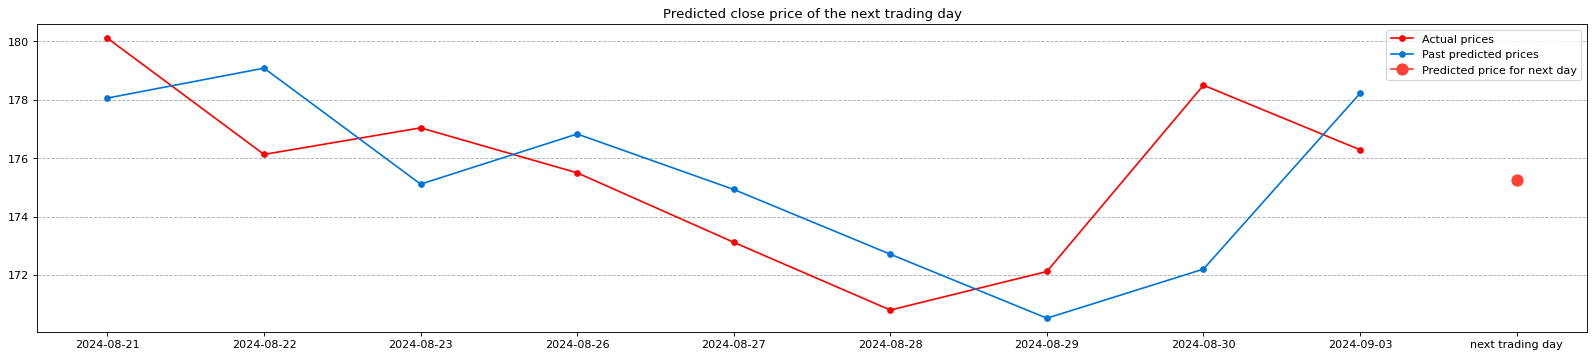

Predicted close price of the next trading day: 175.25


In [98]:
# predict on the unseen data, tomorrow's price

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:

    # prepare plots

    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = data_date[-plot_range+1:]
    plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid( which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))